# Reading OccurrenceCubeWERBirds data

The following script helps to produce a spatial GRID datasets from a GBIF data collection -which has the EEA-GRID ID as attribute.
https://www.gbif.org/

 The script used the donwloaded occurence CSV file, where the geospatial reference is provided by a text code for the EEA reference grid cell identifiers, e.g. 1kmE5432N4321 or 250mE1025N22000 to prode a raster (tif) and vector grid.






THE FOLLOWING CSV FILE SHOWS THE OCCURENCE OF BIRDS

The source data is a 
[CSV file](https://github.com/FAIRiCUBE/data-requests/blob/main/encoding-examples/datacube_nl_farmland_birds_1.csv)  with the following columns:
Year, EEA Grid Cell, TaxonID, Count, Uncertainty

In [21]:
## read the csv file:
import pandas as pd
# URL of the CSV file
#url = "https://github.com/FAIRiCUBE/data-requests/blob/main/encoding-examples/datacube_nl_farmland_birds_1.csv"
csv_url = "https://raw.githubusercontent.com/FAIRiCUBE/data-requests/main/encoding-examples/datacube_nl_farmland_birds_1.csv"
df=pd.read_csv(csv_url)
# add header:
df.columns = ['year', 'gridnum_10m', 'species_id','Count','Uncertainty']
# Display the first few rows of the DataFrame
print(df)


      year        gridnum_10m  species_id  Count  Uncertainty
0     2018  10mE401855N329204     2480242      1       5000.0
1     2018  10mE401856N328589     2490266      1       5000.0
2     2018  10mE401868N329051     2494686      1       5000.0
3     2018  10mE401888N328568     2481819      1       5000.0
4     2018  10mE401894N329338     2480242      1       5000.0
...    ...                ...         ...    ...          ...
3982  2018  10mE408294N330390     2481714      1       5000.0
3983  2018  10mE408295N330620     7788295      1       5000.0
3984  2018  10mE408308N330427     2480242      1       5000.0
3985  2018  10mE408311N330554     9809229      1       5000.0
3986  2018  10mE408324N330443     8332393      1       5000.0

[3987 rows x 5 columns]


The next code extract the coordinates form the EEA GRID ID:

In [22]:

# Extraxt the EAST coordinate
def extract_east_number(text):
    numbers = re.findall(r'\d+', text)
    if len(numbers) >= 2:
        return int(numbers[1])  # Extract the second number
    else:
        return None

# Extraxt the NORTH coordinate
def extract_north_number(text):
    numbers = re.findall(r'\d+', text)
    if len(numbers) >= 2:
        return int(numbers[2])  # Extract the second number
    else:
        return None

# Apply the function to the text_column and create a new column
df['east_number'] = df['gridnum_10m'].apply(lambda x: extract_east_number(x))
df['north_number'] = df['gridnum_10m'].apply(lambda x: extract_north_number(x))

## get final coordinate: - for 10m reslolution:
df['east_coordinate_epsg3035_meter'] = df['east_number'] * 10
df['north_coordinate_epsg3035_meter'] = df['north_number'] * 10


print (df)



      year        gridnum_10m  species_id  Count  Uncertainty  east_number  \
0     2018  10mE401855N329204     2480242      1       5000.0       401855   
1     2018  10mE401856N328589     2490266      1       5000.0       401856   
2     2018  10mE401868N329051     2494686      1       5000.0       401868   
3     2018  10mE401888N328568     2481819      1       5000.0       401888   
4     2018  10mE401894N329338     2480242      1       5000.0       401894   
...    ...                ...         ...    ...          ...          ...   
3982  2018  10mE408294N330390     2481714      1       5000.0       408294   
3983  2018  10mE408295N330620     7788295      1       5000.0       408295   
3984  2018  10mE408308N330427     2480242      1       5000.0       408308   
3985  2018  10mE408311N330554     9809229      1       5000.0       408311   
3986  2018  10mE408324N330443     8332393      1       5000.0       408324   

      north_number  east_coordinate_epsg3035_meter  \
0        

The following notebook produced raster files (tif format) in EPSG:3035 projection from the species table:

--> please add you outputfile path & grid size:

In [24]:
# add outputfolder:
output_raster_tif_folder = r"N:\C2205_FAIRiCUBE\f02_data\d100_species_distribution\data"

# add size of the grid:
grid_size = 10 ## add. the cell size in meter


In [72]:

# geometry:
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.wkt import loads
import geodatasets
import matplotlib.pyplot as plt
import rasterio
from rasterio import features
from rasterio.features import rasterize
from rasterio.transform import from_bounds
from rasterio import Affine

################################################################## INPUT
selected_species = 2494686  ## for testing we only select one species
side_length = grid_size

df=pd.read_csv(csv_url)
df.columns = ['year', 'gridnum_10m', 'species_id','Count','Uncertainty']
unique_species_ids = df['species_id'].unique().tolist()
print(unique_species_ids)

##################################################################

## START



for selected_species in unique_species_ids:
    print (selected_species)


    df=pd.read_csv(csv_url)
    # add header:
    df.columns = ['year', 'gridnum_10m', 'species_id','Count','Uncertainty']
   


    ## select species:
    filtered_df = df[df['species_id'] ==  selected_species]
    df =  filtered_df


    # Extraxt the EAST coordinate
    def extract_east_number(text):
        numbers = re.findall(r'\d+', text)
        if len(numbers) >= 2:
            return int(numbers[1])  # Extract the second number
        else:
            return None

    # Extraxt the NORTH coordinate
    def extract_north_number(text):
        numbers = re.findall(r'\d+', text)
        if len(numbers) >= 2:
            return int(numbers[2])  # Extract the second number
        else:
            return None

    # Apply the function to the text_column and create a new column
    df['east_number'] = df['gridnum_10m'].apply(lambda x: extract_east_number(x))
    df['north_number'] = df['gridnum_10m'].apply(lambda x: extract_north_number(x))

    ## get final coordinate: - for 10m reslolution:
    df['east_coordinate_epsg3035_meter'] = df['east_number'] * 10
    df['north_coordinate_epsg3035_meter'] = df['north_number'] * 10


    #print (df)
    ## geometry to df:
    # Create geometry column using latitude and longitude

    geometry = [Point(xy) for xy in zip(df['east_coordinate_epsg3035_meter'], df['north_coordinate_epsg3035_meter'])]


    # Convert DataFrame to GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=geometry)


    ## build square polygon from point: from lower left starting:

    def create_square_polygon(row, side_length):
        # Define the coordinates of the square's vertices
        north_point = Point(row['geometry'].x, row['geometry'].y + side_length)
        west_point = Point(row['geometry'].x + side_length, row['geometry'].y)
        northwest_point = Point(row['geometry'].x + side_length, row['geometry'].y + side_length)

        # Create the square polygon
        square = Polygon([row['geometry'], north_point, northwest_point, west_point, row['geometry']])
        
        return square

     ## size of the GRIDCELL

    # Apply the create_square_polygon function to each row of the GeoDataFrame
    gdf['square_polygon'] = gdf.apply(create_square_polygon, args=(side_length,), axis=1)


    # Convert DataFrame to GeoDataFrame
    gdf_vector_grid = gpd.GeoDataFrame(gdf, geometry='square_polygon')

    # Specify the projection
    gdf_vector_grid.crs = "EPSG:3035" 



    ## map the data:
    #gdf_vector_grid.explore()

    # Export the GeoDataFrame to a shapefile
    # Export gdf.to_file(output_shapefile)
    # Define the file path for the shapefile
    output_shapefile = output_raster_tif_folder + "\species_"+ str(selected_species) +"_vector_"+str(side_length)+"m.shp"
    # Export the GeoDataFrame to a shapefile
    #print (output_shapefile)
    gdf_vector_grid_export = gdf_vector_grid.drop(columns=['geometry'])  ## remove one geometry to be able to write shp
    gdf_vector_grid_export.to_file(output_shapefile, index=False, geometry='square_polygon')

    ## vector to raster:##############################################################
    # Assuming you have a GeoDataFrame named 'gdf' with geometry column containing polygons

    gdf = gdf_vector_grid


    #gdf = gpd.read_file(output_shapefile)
    # Define the bounds and resolution of the raster
    xmin, ymin, xmax, ymax = gdf.total_bounds  # Get the bounds of the GeoDataFrame
    resolution = side_length  # Define the resolution of the raster (adjust as needed)

    # Calculate the number of rows and columns in the raster
    rows = int((ymax - ymin) / resolution)
    cols = int((xmax - xmin) / resolution)

    # Define the transform for the raster
    #resolution is the pixel size (assumed to be 10 meters).
    #xmin is the x-coordinate of the upper-left corner.
    #ymax is the y-coordinate of the upper-left corner.

    #transform = Affine(resolution, 0, xmin, 0, - resolution, ymax)

   
    transform = Affine(resolution, 0, xmin, 0, - resolution, ymax)  # shifting the raster 10m to the south

    output_raster_tif = output_raster_tif_folder + "\species_"+ str(selected_species) +"_raster_"+str(side_length)+"m.tif"


    # Create an empty raster
    with rasterio.open(output_raster_tif, 'w', driver='GTiff', 
                    height=rows, width=cols, count=1, dtype='float64', 
                    crs=gdf.crs, transform=transform) as dst:
        # Rasterize the GeoDataFrame onto the raster using attribute values
        rasterized = rasterize(
            [(geom, value) for geom, value in zip(gdf['geometry'], gdf['species_id'])],
            out_shape=(rows, cols),
            fill=0,
            transform=dst.transform,
            all_touched=True,
            dtype='float64'
        )
        
        # Write the rasterized data to the raster file
        dst.write(rasterized, indexes=1)

    print("Raster file created successfully.")

print ("done")

[2480242, 2490266, 2494686, 2481819, 2481714, 9515886, 9809229, 9616058, 9701857, 2481685, 8077224, 8332393, 2492943, 5231198, 7788295, 2490774, 8250742, 2495708, 7634625, 2474156, 2481792, 2493220, 2491534, 2482513, 2497266]
2480242


C:\Users\ManuelLöhnertz\AppData\Local\Temp\ipykernel_40640\2767848509.py:117: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_vector_grid_export.to_file(output_shapefile, index=False, geometry='square_polygon')


Raster file created successfully.
2490266


C:\Users\ManuelLöhnertz\AppData\Local\Temp\ipykernel_40640\2767848509.py:117: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_vector_grid_export.to_file(output_shapefile, index=False, geometry='square_polygon')


Raster file created successfully.
2494686


C:\Users\ManuelLöhnertz\AppData\Local\Temp\ipykernel_40640\2767848509.py:117: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_vector_grid_export.to_file(output_shapefile, index=False, geometry='square_polygon')


Raster file created successfully.
2481819


C:\Users\ManuelLöhnertz\AppData\Local\Temp\ipykernel_40640\2767848509.py:117: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_vector_grid_export.to_file(output_shapefile, index=False, geometry='square_polygon')


Raster file created successfully.
2481714


C:\Users\ManuelLöhnertz\AppData\Local\Temp\ipykernel_40640\2767848509.py:117: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_vector_grid_export.to_file(output_shapefile, index=False, geometry='square_polygon')


Raster file created successfully.
9515886


C:\Users\ManuelLöhnertz\AppData\Local\Temp\ipykernel_40640\2767848509.py:117: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_vector_grid_export.to_file(output_shapefile, index=False, geometry='square_polygon')


Raster file created successfully.
9809229


C:\Users\ManuelLöhnertz\AppData\Local\Temp\ipykernel_40640\2767848509.py:117: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_vector_grid_export.to_file(output_shapefile, index=False, geometry='square_polygon')


Raster file created successfully.
9616058


C:\Users\ManuelLöhnertz\AppData\Local\Temp\ipykernel_40640\2767848509.py:117: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_vector_grid_export.to_file(output_shapefile, index=False, geometry='square_polygon')


Raster file created successfully.
9701857


C:\Users\ManuelLöhnertz\AppData\Local\Temp\ipykernel_40640\2767848509.py:117: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_vector_grid_export.to_file(output_shapefile, index=False, geometry='square_polygon')


Raster file created successfully.
2481685


C:\Users\ManuelLöhnertz\AppData\Local\Temp\ipykernel_40640\2767848509.py:117: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_vector_grid_export.to_file(output_shapefile, index=False, geometry='square_polygon')


Raster file created successfully.
8077224


C:\Users\ManuelLöhnertz\AppData\Local\Temp\ipykernel_40640\2767848509.py:117: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_vector_grid_export.to_file(output_shapefile, index=False, geometry='square_polygon')


Raster file created successfully.
8332393


C:\Users\ManuelLöhnertz\AppData\Local\Temp\ipykernel_40640\2767848509.py:117: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_vector_grid_export.to_file(output_shapefile, index=False, geometry='square_polygon')


Raster file created successfully.
2492943


C:\Users\ManuelLöhnertz\AppData\Local\Temp\ipykernel_40640\2767848509.py:117: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_vector_grid_export.to_file(output_shapefile, index=False, geometry='square_polygon')


Raster file created successfully.
5231198


C:\Users\ManuelLöhnertz\AppData\Local\Temp\ipykernel_40640\2767848509.py:117: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_vector_grid_export.to_file(output_shapefile, index=False, geometry='square_polygon')


Raster file created successfully.
7788295


C:\Users\ManuelLöhnertz\AppData\Local\Temp\ipykernel_40640\2767848509.py:117: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_vector_grid_export.to_file(output_shapefile, index=False, geometry='square_polygon')


Raster file created successfully.
2490774


C:\Users\ManuelLöhnertz\AppData\Local\Temp\ipykernel_40640\2767848509.py:117: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_vector_grid_export.to_file(output_shapefile, index=False, geometry='square_polygon')


Raster file created successfully.
8250742


C:\Users\ManuelLöhnertz\AppData\Local\Temp\ipykernel_40640\2767848509.py:117: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_vector_grid_export.to_file(output_shapefile, index=False, geometry='square_polygon')


Raster file created successfully.
2495708


C:\Users\ManuelLöhnertz\AppData\Local\Temp\ipykernel_40640\2767848509.py:117: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_vector_grid_export.to_file(output_shapefile, index=False, geometry='square_polygon')


Raster file created successfully.
7634625


C:\Users\ManuelLöhnertz\AppData\Local\Temp\ipykernel_40640\2767848509.py:117: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_vector_grid_export.to_file(output_shapefile, index=False, geometry='square_polygon')


Raster file created successfully.
2474156


C:\Users\ManuelLöhnertz\AppData\Local\Temp\ipykernel_40640\2767848509.py:117: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_vector_grid_export.to_file(output_shapefile, index=False, geometry='square_polygon')


Raster file created successfully.
2481792


C:\Users\ManuelLöhnertz\AppData\Local\Temp\ipykernel_40640\2767848509.py:117: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_vector_grid_export.to_file(output_shapefile, index=False, geometry='square_polygon')


Raster file created successfully.
2493220


C:\Users\ManuelLöhnertz\AppData\Local\Temp\ipykernel_40640\2767848509.py:117: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_vector_grid_export.to_file(output_shapefile, index=False, geometry='square_polygon')


Raster file created successfully.
2491534


C:\Users\ManuelLöhnertz\AppData\Local\Temp\ipykernel_40640\2767848509.py:117: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_vector_grid_export.to_file(output_shapefile, index=False, geometry='square_polygon')


Raster file created successfully.
2482513


C:\Users\ManuelLöhnertz\AppData\Local\Temp\ipykernel_40640\2767848509.py:117: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_vector_grid_export.to_file(output_shapefile, index=False, geometry='square_polygon')


Raster file created successfully.
2497266


C:\Users\ManuelLöhnertz\AppData\Local\Temp\ipykernel_40640\2767848509.py:117: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_vector_grid_export.to_file(output_shapefile, index=False, geometry='square_polygon')


Raster file created successfully.
done


In [78]:
from osgeo import gdal  # shifting with gdasl
shift_y = 10
input_ds = gdal.Open(r"N:\C2205_FAIRiCUBE\f02_data\d100_species_distribution\data\species_2490266_raster_10m.tif", gdal.GA_ReadOnly)
geo_transform = input_ds.GetGeoTransform()
new_geo_transform = list(geo_transform)
new_geo_transform[3] += shift_y
# Create a new dataset with the modified GeoTransform
driver = input_ds.GetDriver()

input_ds.SetGeoTransform(new_geo_transform)


output_ds = driver.CreateCopy(r"N:\C2205_FAIRiCUBE\f02_data\d100_species_distribution\data\species_2490266_raster_10m_gdal.tif", input_ds)


In [104]:
### test with shift:

# geometry:
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.wkt import loads
import geodatasets
import matplotlib.pyplot as plt
import rasterio
from rasterio import features
from rasterio.features import rasterize
from rasterio.transform import from_bounds
from rasterio import Affine


from osgeo import gdal  # shifting with gdasl

################################################################## INPUT
selected_species = 2494686  ## for testing we only select one species
side_length = grid_size

df=pd.read_csv(csv_url)
df.columns = ['year', 'gridnum_10m', 'species_id','Count','Uncertainty']
unique_species_ids = df['species_id'].unique().tolist()
print(unique_species_ids)

##################################################################

## START



for selected_species in unique_species_ids:
    print (selected_species)


    df=pd.read_csv(csv_url)
    # add header:
    df.columns = ['year', 'gridnum_10m', 'species_id','Count','Uncertainty']
   


    ## select species:
    filtered_df = df[df['species_id'] ==  selected_species]
    df =  filtered_df


    # Extraxt the EAST coordinate
    def extract_east_number(text):
        numbers = re.findall(r'\d+', text)
        if len(numbers) >= 2:
            return int(numbers[1])  # Extract the second number
        else:
            return None

    # Extraxt the NORTH coordinate
    def extract_north_number(text):
        numbers = re.findall(r'\d+', text)
        if len(numbers) >= 2:
            return int(numbers[2])  # Extract the second number
        else:
            return None

    # Apply the function to the text_column and create a new column
    df['east_number'] = df['gridnum_10m'].apply(lambda x: extract_east_number(x))
    df['north_number'] = df['gridnum_10m'].apply(lambda x: extract_north_number(x))

    ## get final coordinate: - for 10m reslolution:
    df['east_coordinate_epsg3035_meter'] = df['east_number'] * 10
    df['north_coordinate_epsg3035_meter'] = df['north_number'] * 10


    #print (df)
    ## geometry to df:
    # Create geometry column using latitude and longitude

    geometry = [Point(xy) for xy in zip(df['east_coordinate_epsg3035_meter'], df['north_coordinate_epsg3035_meter'])]


    # Convert DataFrame to GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=geometry)


    ## build square polygon from point: from lower left starting:

    def create_square_polygon(row, side_length):
        # Define the coordinates of the square's vertices
        north_point = Point(row['geometry'].x, row['geometry'].y + side_length)
        west_point = Point(row['geometry'].x + side_length, row['geometry'].y)
        northwest_point = Point(row['geometry'].x + side_length, row['geometry'].y + side_length)

        # Create the square polygon
        square = Polygon([row['geometry'], north_point, northwest_point, west_point, row['geometry']])
        
        return square

     ## size of the GRIDCELL

    # Apply the create_square_polygon function to each row of the GeoDataFrame
    gdf['square_polygon'] = gdf.apply(create_square_polygon, args=(side_length,), axis=1)


    # Convert DataFrame to GeoDataFrame
    gdf_vector_grid = gpd.GeoDataFrame(gdf, geometry='square_polygon')

    # Specify the projection
    gdf_vector_grid.crs = "EPSG:3035" 



    ## map the data:
    #gdf_vector_grid.explore()

    # Export the GeoDataFrame to a shapefile
    # Export gdf.to_file(output_shapefile)
    # Define the file path for the shapefile
    output_shapefile = output_raster_tif_folder + "\species_"+ str(selected_species) +"_vector_"+str(side_length)+"m.shp"
    # Export the GeoDataFrame to a shapefile
    #print (output_shapefile)
    gdf_vector_grid_export = gdf_vector_grid.drop(columns=['geometry'])  ## remove one geometry to be able to write shp
    gdf_vector_grid_export.to_file(output_shapefile, index=False, geometry='square_polygon')

    ## vector to raster:##############################################################
    # Assuming you have a GeoDataFrame named 'gdf' with geometry column containing polygons

    gdf = gdf_vector_grid


    #gdf = gpd.read_file(output_shapefile)
    # Define the bounds and resolution of the raster
    xmin, ymin, xmax, ymax = gdf.total_bounds  # Get the bounds of the GeoDataFrame
    resolution = side_length  # Define the resolution of the raster (adjust as needed)

    # Calculate the number of rows and columns in the raster
    rows = int((ymax - ymin) / resolution)
    cols = int((xmax - xmin) / resolution)

    # Define the transform for the raster
    #resolution is the pixel size (assumed to be 10 meters).
    #xmin is the x-coordinate of the upper-left corner.
    #ymax is the y-coordinate of the upper-left corner.

    #transform = Affine(resolution, 0, xmin, 0, - resolution, ymax)

   
    transform = Affine(resolution, 0, xmin, 0, - resolution, ymax)  # shifting the raster 10m to the south

    output_raster_tif = output_raster_tif_folder + "\species_"+ str(selected_species) +"_raster_"+str(side_length)+"m.tif"


    # Create an empty raster
    with rasterio.open(output_raster_tif, 'w', driver='GTiff', 
                    height=rows, width=cols, count=1, dtype='float64', 
                    crs=gdf.crs, transform=transform) as dst:
        # Rasterize the GeoDataFrame onto the raster using attribute values
        rasterized = rasterize(
            [(geom, value) for geom, value in zip(gdf['geometry'], gdf['species_id'])],
            out_shape=(rows, cols),
            fill=0,
            transform=dst.transform,
            all_touched=True,
            dtype='float64'
        )
        
        # Write the rasterized data to the raster file
        dst.write(rasterized, indexes=1)
    	

        
        shift_y = 10
        print ("gdal:")
        print (output_raster_tif)

        #input_x = "r"+'"'+output_raster_tif+'"'
        #print (input_x)

        gdal_input =   "N:/C2205_FAIRiCUBE/f02_data/d100_species_distribution/data/"+   "species_"+ str(selected_species) +"_raster_"+str(side_length)+"m.tif"
        print (gdal_input)
        input_ds = gdal.Open(gdal_input, gdal.GA_ReadOnly)

        #input_ds = gdal.Open(r"N:\C2205_FAIRiCUBE\f02_data\d100_species_distribution\data\species_2480242_raster_10m.tif", gdal.GA_ReadOnly)
        #input_ds = gdal.Open(input_x,  gdal.GA_ReadOnly)
        geo_transform = input_ds.GetGeoTransform()
        new_geo_transform = list(geo_transform)
        new_geo_transform[3] += shift_y
        # Create a new dataset with the modified GeoTransform
        driver = input_ds.GetDriver()

        input_ds.SetGeoTransform(new_geo_transform)

        output_raster_tif_gdal = output_raster_tif_folder + "\species_"+ str(selected_species) +"_raster_"+str(side_length)+"m_gdal.tif"
        output_ds = driver.CreateCopy(output_raster_tif_gdal, input_ds)



    print("Raster file created successfully.")

print ("done")

[2480242, 2490266, 2494686, 2481819, 2481714, 9515886, 9809229, 9616058, 9701857, 2481685, 8077224, 8332393, 2492943, 5231198, 7788295, 2490774, 8250742, 2495708, 7634625, 2474156, 2481792, 2493220, 2491534, 2482513, 2497266]
2480242


C:\Users\ManuelLöhnertz\AppData\Local\Temp\ipykernel_40640\731143490.py:122: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_vector_grid_export.to_file(output_shapefile, index=False, geometry='square_polygon')


gdal:
N:\C2205_FAIRiCUBE\f02_data\d100_species_distribution\data\species_2480242_raster_10m.tif
N:/C2205_FAIRiCUBE/f02_data/d100_species_distribution/data/species_2480242_raster_10m.tif


AttributeError: 'NoneType' object has no attribute 'GetGeoTransform'

In [86]:
rasterized


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Raster shifted one pixel south and saved as 'shifted_raster.tif'


Show the results:

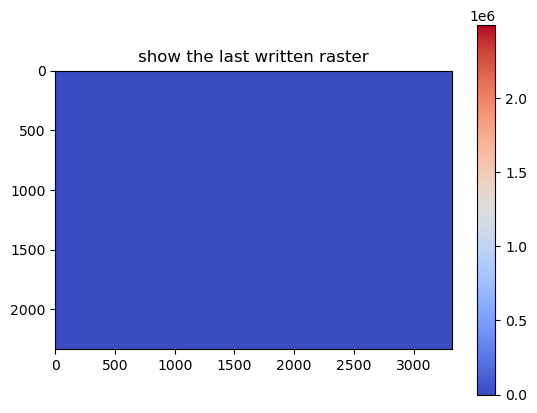

In [40]:
# Load your raster file (replace 'your_raster.tif' with your actual file path)
raster_path = output_raster_tif
with rasterio.open(raster_path) as src:
    raster_array = src.read(1)  # Read the first band (adjust if needed)




plt.imshow(raster_array, cmap='coolwarm')  # You can choose a colormap (e.g., 'gray')
plt.colorbar()  # Add a colorbar if desired
plt.title("show the last written raster")
plt.show()

Problem:

![alternatvie text]("C:\Users\ManuelLöhnertz\projects\uc1-urban-climate\notebooks\dev\f06_mixed\info_image_gridcell_problematic_1.JPG")


<img src="C:\Users\ManuelLöhnertz\projects\uc1-urban-climate\notebooks\dev\f06_mixed\info_image_gridcell_problematic_1.JPG" alt="Alternative text" />

![drought_sat_images]("info_image_gridcell_problematic_1.JPG")
